# Parte 1: Análisis exploratorio

Esta primera parte del trabajo práctico se centra en explorar el dataset e intentar entender el target que se buscará predecir.

In [100]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from wordcloud import WordCloud
from gensim.models import KeyedVectors
import re

# suprimir future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


SEED = 4237
np.random.seed(SEED)
random.seed(SEED)
CUSTOM_PALLETE = ["#00A7E1", "#FFA630"]


In [101]:
import pandas as pd
train_path = 'data/train.csv'
df = pd.read_csv(train_path)
random_sample = random.sample(range(len(df)), 10)
df.take(random_sample)

,id,keyword,location,text,target
299,440,apocalypse,NaN,The latest from @BryanSinger reveals #Storm is...,1
7458,10673,wounds,Alex/Mika/Leo|18|he/she/they,@ego_resolution im glad. My gay can heal 1000 ...,0
4160,5909,harm,England,@VileLunar I trickshot with a regular controll...,0
350,502,army,NaN,17.Beyonce Is my pick for http://t.co/thoYhrHk...,0
4468,6354,hostages,NaN,No #news of #hostages in #Libya\n\nhttp://t.co...,1
1704,2459,collided,"Peterborough, On",#Newswatch: 2 vehicles collided at Lock and La...,1
4825,6870,mass%20murder,NaN,@guardian Has Japan ever truly come to terms w...,1
2835,4079,displaced,"Oakland, CA",Historic flooding across Asia leaves hundreds ...,1
7512,10745,wreckage,khanna,Wreckage 'Conclusively Confirmed' as From MH37...,1
947,1372,blown%20up,"Grimsby, England",My dogÛªs just blown his kennel up ÛÒ Bloody...,0


Se puede observar que el contenido del dataset es variado.
- En el campo `keyword` se pueden ver palabras clave posiblemente relacionadas con un desastre extraidas del tweet.
- El campo `location` se puede suponer que es la ubicación mencionada en el perfil del usuario que escribió el tweet. Es importante destacar que ese campo puede ser nulo o un string ingresado por el usuario, por lo que no solo puede contener ubicaciones con diferentes formatos y "granularidades" (por ejemplo podemos observar 'Grimsby, England', además de 'England'), sino que lo que contiene no necesariamente es una ubicación real (por ejemplo podemos encontrar edad, pronombres y lo que parecen ser nombres en la fila de id 10673).
- El campo `text` es el tweet en sí, como texto plano. Contiene menciones, hashtags, enlaces y otros caracteres unicode que se perdieron en alguna codificación. Todos los tweets que revisé están en inglés, por lo que supongo como mínimo que es el idioma predominante en el set de datos.

A continuación se pueden observar métricas del dataset.

In [102]:
print('Shape:', df.shape)
target_sum = df['target'].sum()
print(f"Cantidad de tweets \"Desastre\": {target_sum}")
print(f"Cantidad de tweets \"No Desastre\": {df['target'].count() - target_sum}")
df.describe()

Shape: (7613, 5)
Cantidad de tweets "Desastre": 3271
Cantidad de tweets "No Desastre": 4342


,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


Lo más destacable es que las clases de tweets (Desastres y No Desastres) están relativamente balanceadas en el set de datos (~3000 y ~4000 respectivamente). \
Tomé la hipótesis que el set está suficientemente balanceado, por lo que opté por no utilizar técnicas de oversampling ni undersampling que, realizadas de forma errónea, podrían dificultar el entrenamiento.

A continuación realizo una limpieza y preprocesamiento básico de texto, además de calcular las features que se mostrarán en las visualizaciones.\
Cabe destacar que estas no son todas las features que usa el modelo, pero me parecieron las más interesantes e intuitivas de graficar.

In [103]:
def clean_text(s):
    if pd.isna(s):
        return ''
    s = str(s)
    s = s.lower()
    s = re.sub(r'http\S+', ' ', s)
    s = re.sub(r'www\S+', ' ', s)
    s = re.sub(r'[^\w\s#@]', ' ', s)
    s = re.sub(r'[\s_]+', ' ', s).strip()
    return s

df['text_clean'] = df['text'].apply(clean_text)
df['keyword'] = df['keyword'].fillna('no_keyword_contained')
df['location'] = df['location'].fillna('no_location_contained')
df['text_len'] = df['text_clean'].apply(lambda s: sum(len(w) for w in s.split()))
df['word_count'] = df['text_clean'].apply(lambda s: len(s.split()))
df['mean_word_len'] = df.apply(lambda row: row['text_len'] / row['word_count'] if row['word_count'] > 0 else 0, axis=1)
df['num_hashtags'] = df['text'].apply(lambda s: 0 if pd.isna(s) else s.count('#'))
df['num_mentions'] = df['text'].apply(lambda s: 0 if pd.isna(s) else s.count('@'))
df['has_url'] = df['text'].apply(lambda s: 0 if pd.isna(s) else (1 if 'http' in s or 'www.' in s else 0))

disaster_terms = df['keyword'].dropna().unique().tolist()
def count_terms(s, terms=disaster_terms):
    s = s.lower()
    cnt = 0
    for t in terms:
        if t in s:
            cnt += 1
    return cnt
df['disaster_terms_count'] = df['text_clean'].apply(count_terms)

df['all_caps_count'] = df['text'].apply(lambda s: sum(1 for w in str(s).split() if w.isupper())).fillna(0)

df[['text_len','word_count','mean_word_len','num_hashtags','num_mentions','has_url','disaster_terms_count', 'all_caps_count']].describe().T

,count,mean,std,min,25%,50%,75%,max
text_len,7613.0,70.222645,26.389220,5.0,50.000000,72.00,91.000000,125.0
word_count,7613.0,14.664259,6.125010,1.0,10.000000,15.00,19.000000,34.0
mean_word_len,7613.0,4.968473,1.064258,2.0,4.235294,4.85,5.526316,13.0
num_hashtags,7613.0,0.446999,1.099841,0.0,0.000000,0.00,0.000000,13.0
num_mentions,7613.0,0.362406,0.720097,0.0,0.000000,0.00,1.000000,8.0
has_url,7613.0,0.521608,0.499566,0.0,0.000000,1.00,1.000000,1.0
disaster_terms_count,7613.0,1.374097,0.866296,0.0,1.000000,1.00,2.000000,7.0
all_caps_count,7613.0,0.933929,2.010867,0.0,0.000000,0.00,1.000000,25.0


## Visualizaciones

### 1. Distribución de longitudes del tweet según target

Para comenzar realicé un boxplot para visualizar la distribución de las longitudes de los tweets.\
Se diferencian dos gráficos, uno que usa la longitud de caracteres del tweet y otro la longitud de palabras.

Se puede observar que en líneas generales las distribuciones son muy similares. \
Sin embargo aún así se puede notar que la longitud en caracteres de los tweets de la clase Desastres es ligeramente mayor, teniendo una caja más chica (i.e. menos varianza en la longitud) y una mediana más alta. \
Observar esto me dió una idea: ya que los tweets de Desastres tienen más o menos la misma longitud en palabras pero una longitud un poco mayor en caracteres, estos quizás tienden a utilizar palabras más altas. Intento visualizar esa idea en el siguiente gráfico.

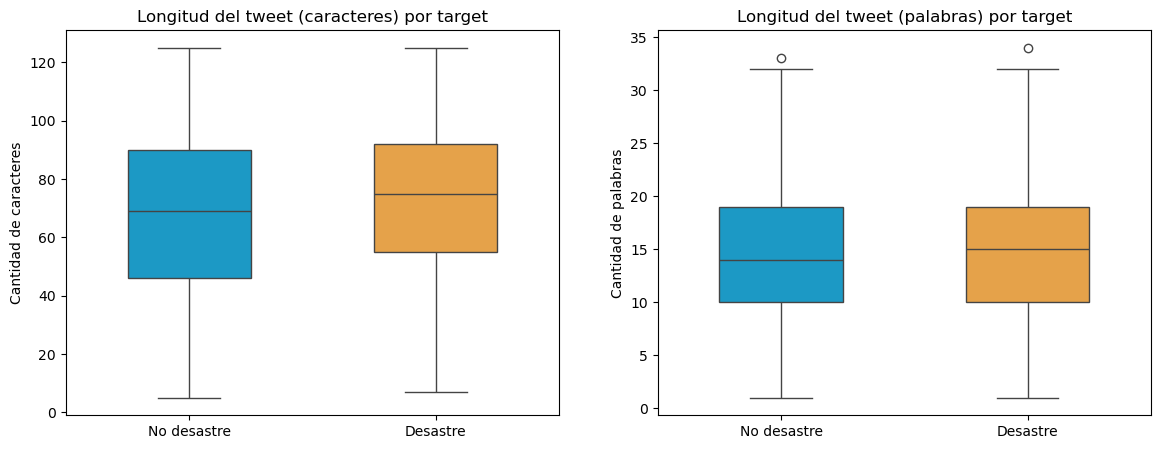

In [104]:
fig, axes = plt.subplots(1,2, figsize=(14,5))
sns.boxplot(x='target', y='text_len', data=df, palette=CUSTOM_PALLETE, width=0.5, ax=axes[0])
axes[0].set_title('Longitud del tweet (caracteres) por target')
axes[0].set_xlabel('')
axes[0].set_xticks([0,1], ['No desastre', 'Desastre'])
axes[0].set_ylabel('Cantidad de caracteres')

sns.boxplot(x='target', y='word_count', data=df, palette=CUSTOM_PALLETE, width=0.5, ax=axes[1])
axes[1].set_title('Longitud del tweet (palabras) por target')
axes[1].set_xlabel('')
axes[1].set_xticks([0,1], ['No desastre', 'Desastre'])
axes[1].set_ylabel('Cantidad de palabras')
plt.show()


Siguiendo la observación de los gráficos anteriores, en este gráfico se visualiza la longitud media de las palabras por target.

Como podría esperarse, se observan distribuciones nuevamente muy similares, pero los tweets de Desastres tienden a tener una longitud media de palabras un poco más alta.

Si bien no es para nada una métrica concluyente, esto podría ayudar a los modelos a distinguir las dos categorías de tweets.

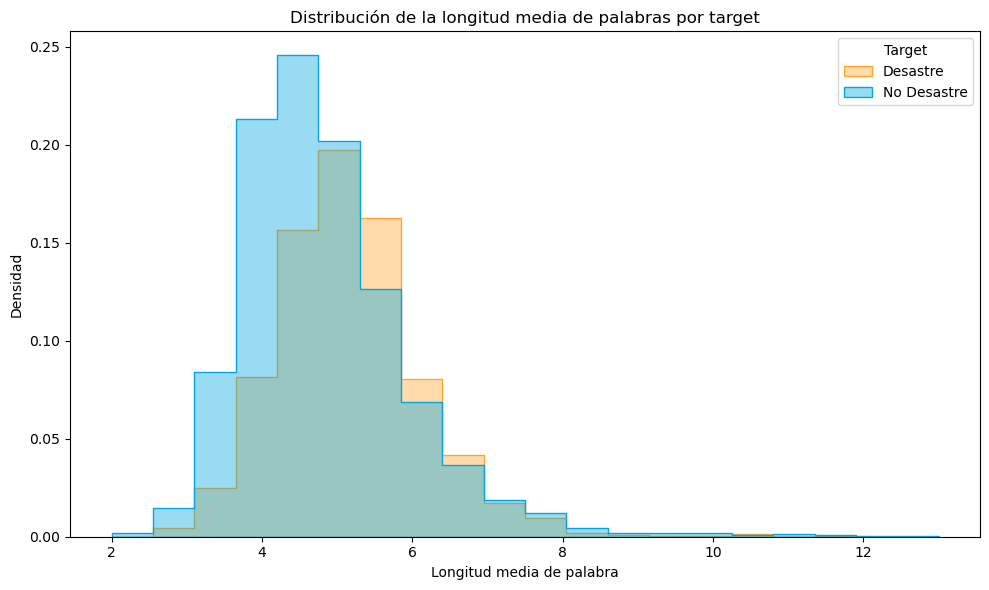

In [105]:
plt.figure(figsize=(10,6))
sns.histplot(
    data=df,
    x='mean_word_len',
    hue='target',
    bins=20,
    palette=CUSTOM_PALLETE,
    alpha=0.4,
    element='step',
    stat='density',
)
plt.title('Distribución de la longitud media de palabras por target')
plt.xlabel('Longitud media de palabra')
plt.ylabel('Densidad')
plt.legend(title='Target', labels=['Desastre', 'No Desastre'])
plt.tight_layout()
plt.show()

### 2. Proporcíon de tweets según si la ubicación es mencionada en el tweet.

El propósito de esta visualización es intentar encontrar una relación entre el campo `location` y el campo `text`. 

Ya sea en una noticia o un tweet de un usuario corriente, uno podría imaginarse que al hablar de un Desastre real una persona podría tender más a mencionar su ubicación. De esta idea surge la visualización mostrada a continuación.

Podemos ver en el heatmap que no necesariamente es el caso. \
En la primera fila, podemos ver claramente que la gran mayoría de tweets de ambas clases no mencionan la ubicación en el tweet. \
En la segunda, podemos ver que aproximadamente el 2.6% de tweets sobre Desastres mencionan la ubicación del usuario en contra de un 1.4% para los tweets de No Desastres. Si bien la diferencia es cercana a un 1%, dado que los porcentajes son tan bajos esa diferencia puede resultar significativa. \
Aún así, este dato evidentemente sigue sin ser concluyente e incluso podría resultar confuso en ciertos contextos para el modelo.

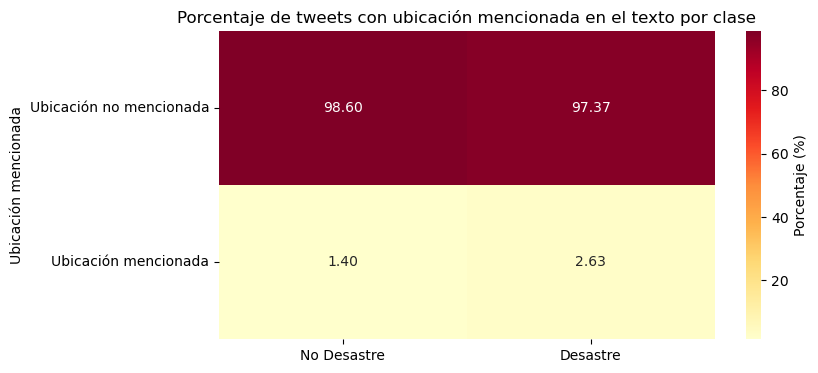

In [106]:
df['location'] = df['location'].apply(clean_text)
df['location_mentioned'] = df.apply(lambda row: 1 if row['location'].lower() in row['text_clean'] else 0, axis=1)
df[['location','location_mentioned']].value_counts()
location_mentioned_by_target = pd.crosstab(df['location_mentioned'], df['target'], normalize='columns') * 100
location_mentioned_by_target.index = ['Ubicación no mencionada', 'Ubicación mencionada']
location_mentioned_by_target.columns = ['No Desastre', 'Desastre']

plt.figure(figsize=(8, 4))
sns.heatmap(location_mentioned_by_target, annot=True, fmt=".2f", cmap='YlOrRd', cbar_kws={'label': 'Porcentaje (%)'})
plt.title('Porcentaje de tweets con ubicación mencionada en el texto por clase')
plt.ylabel('Ubicación mencionada')
plt.yticks(rotation=0)
plt.show()

### 3. Proporción de tweets con URL / hashtags / mentions según target

Las siguientes visualizaciones intentan ver la relación entre el target con la presencia y cantidad de menciones, hashtags y URLs contenidas en el tweet.

Primeramente, podemos observar ahora sí porcentajes más variados en el heatmap.\
Se puede identificar una diferencia marcada en la primera fila, la cual habla de la presencia de URL. Con una diferencia de un 25%, los tweets sobre desastres parecen tender considerablemente más a contener enlaces.

Si bien en las otras filas no hay diferencias tan marcadas (~5% y ~10%), esos datos podrían contribuir a la diferenciación de las clases.

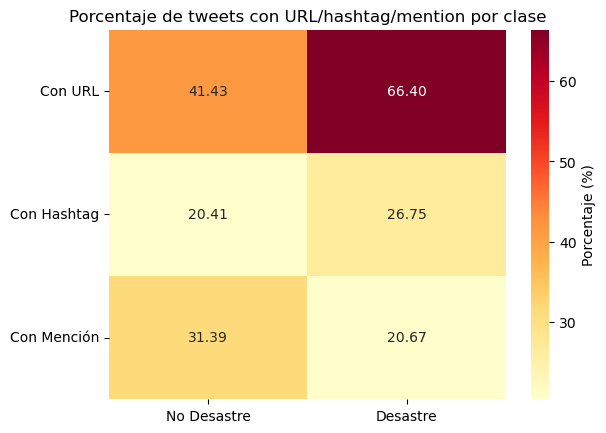

In [107]:
data = pd.DataFrame({
    'Con URL': df.groupby('target')['has_url'].mean()*100,
    'Con Hashtag': (df['num_hashtags']>0).groupby(df['target']).mean()*100,
    'Con Mención': (df['num_mentions']>0).groupby(df['target']).mean()*100
})
data = data.T
data.columns = ['No Desastre','Desastre']
sns.heatmap(data, annot=True, fmt=".2f", cmap='YlOrRd', cbar_kws={'label': 'Porcentaje (%)'})
plt.title('Porcentaje de tweets con URL/hashtag/mention por clase')
plt.yticks(rotation=0)
plt.show()


En el siguiente gráfico de barras no se visualiza la proporción de los tweets que contienen o no contienen los elementos mencionados, sino la media de la cantidad de elementos utilizados.

Nuevamente la diferencia más notoria está en las URLs, sin embargo aún puede notarse cierta diferenciación en hashtags y menciones.

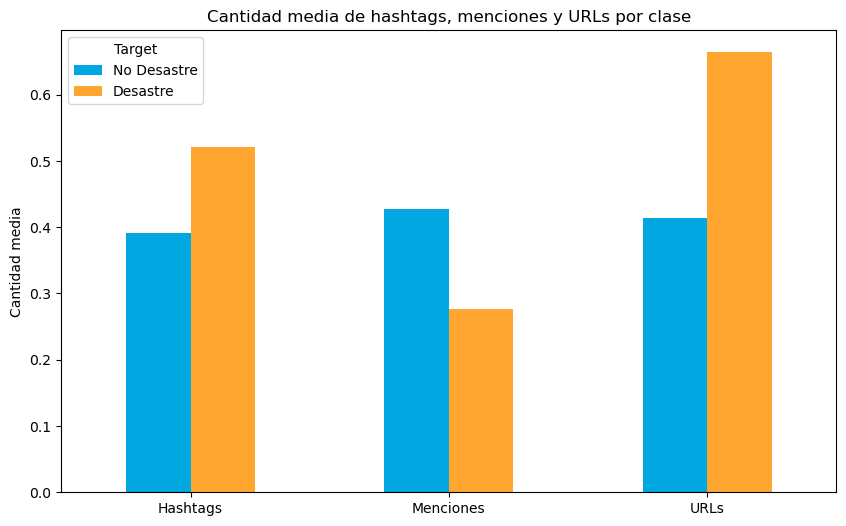

In [108]:
df.groupby('target')[['num_hashtags', 'num_mentions', 'has_url']].mean()
data = df.groupby('target')[['num_hashtags', 'num_mentions', 'has_url']].mean()
data = data.T
data.columns = ['No Desastre', 'Desastre']

data.plot(kind='bar', figsize=(10, 6), color=CUSTOM_PALLETE)
plt.title('Cantidad media de hashtags, menciones y URLs por clase')
plt.ylabel('Cantidad media')
plt.xticks(rotation=0, ticks=range(len(data.index)), labels=['Hashtags', 'Menciones', 'URLs'])
plt.legend(title='Target')
plt.show()

### 4. Cantidad de tweets según cantidad de términos relacionados a desastres y cantidad de palabras en mayúsculas por target

A continuación se observan dos gráficos construidos en el mismo formato pero con datos diferentes.

El primero muestra cantidad de tweets divididos según la cantidad de "términos de desastres" (obtenidos a partir del campo keyword) y por target. \
Lo más relevante a destacar es que la gran mayoría de tweets sobre No Desastres del dataset contienen exactamente una palabra de desastre, mientras que los tweets sobre Desastres son más variados en la cantidad de términos que usan, siendo 1 2 y 3 las cantidades más comunes. \
Otro dato interesante a destacar es que no todos los tweets contienen una keyword contenida. Hice la verificación y hay varios (aunque minoría) tweets con valores no nulos en el campo `keyword` que aún así no hacen mención de ningún término en el texto. En esos casos se puede cuestionar el origen del campo `keyword`, si ese término no está en el tweet ¿de dónde se sacó esa información?

El segundo gráfico como mencioné tiene el mismo formato, las cantidades mostradas son de palabras completamente en mayúsculas del tweet. La cantidad de tweets se muestra en escala logaritmica para facilitar la visualización. También se muestran solamente hasta tweets con 15 palabras en mayúsculas, hay algunos con más de 15 (hasta 25) pero eran muy pocos (entre 0 y 10) y consideré que empobrecían la visualización.\
La idea detrás de esta visualización es que quizás noticias o tweets que expresan pánico en tweets sobre Desastres quizás harían más uso de palabras completamente en mayúsculas. \
Sin embargo esa no fue la realidad. Se observan tendencias muy similares en cuanto a la utilización de palabras completamente en mayúsculas para ambas clases.

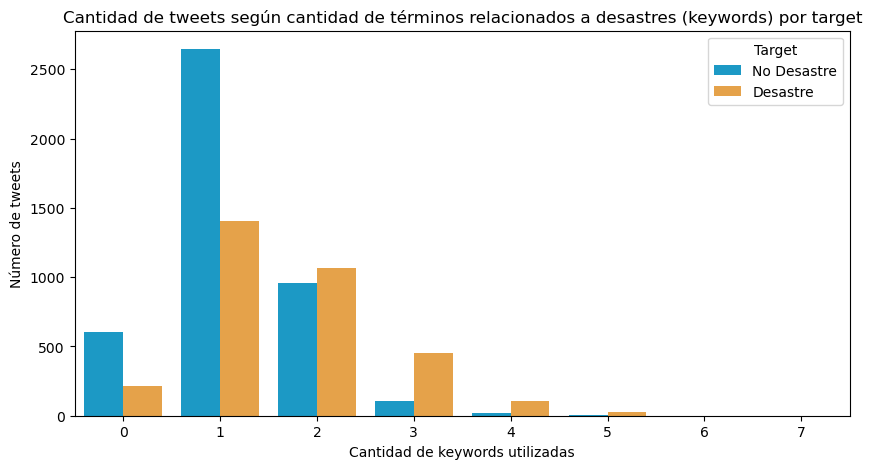

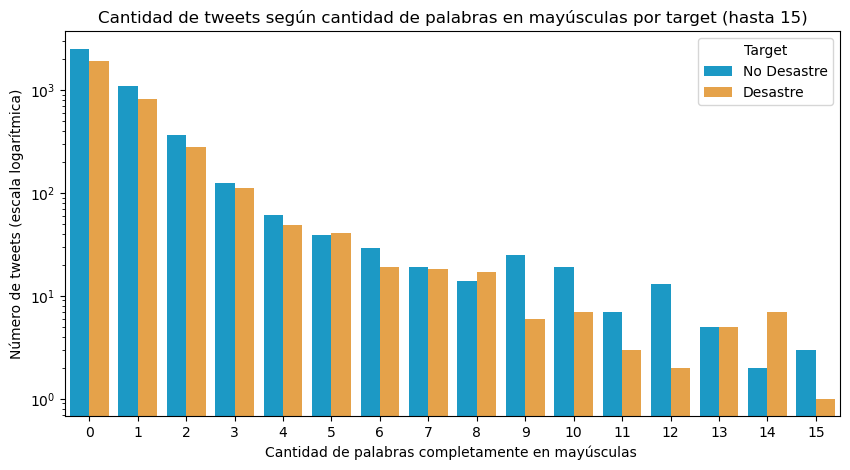

In [109]:
plt.figure(figsize=(10,5))
data = df.groupby(['disaster_terms_count','target']).size().reset_index(name='count')
data['target'] = data['target'].apply(lambda x: "No Desastre" if x == 0 else "Desastre")
sns.barplot(hue='target', x='disaster_terms_count', y='count', data=data, palette=CUSTOM_PALLETE)
plt.title('Cantidad de tweets según cantidad de términos relacionados a desastres (keywords) por target')
plt.xlabel('Cantidad de keywords utilizadas')
plt.ylabel('Número de tweets')
plt.legend(title="Target")
plt.show()

plt.figure(figsize=(10,5))
data = df.groupby(['all_caps_count','target']).size().reset_index(name='count')
data = data[data['all_caps_count'] <= 15]
data['target'] = data['target'].apply(lambda x: "No Desastre" if x == 0 else "Desastre")
sns.barplot(hue='target', x='all_caps_count', y='count', data=data, palette=CUSTOM_PALLETE)
plt.title('Cantidad de tweets según cantidad de palabras en mayúsculas por target (hasta 15)')
plt.xlabel('Cantidad de palabras completamente en mayúsculas ')
plt.ylabel('Número de tweets (escala logarítmica)')
plt.yscale('log')
plt.legend(title="Target")
plt.show()

Por último muestro un grafico de barras apiladas para tener otra vista del primer gráfico de la celda anterior. No se incluyen las cantidades mayors a 5 porque representan muy pocos tweets.

Como se mencionó anteriormente, puede observarse que es mayor la proporción de tweets sobre Desastres cuando la cantidad de términos mencionados es mayor.

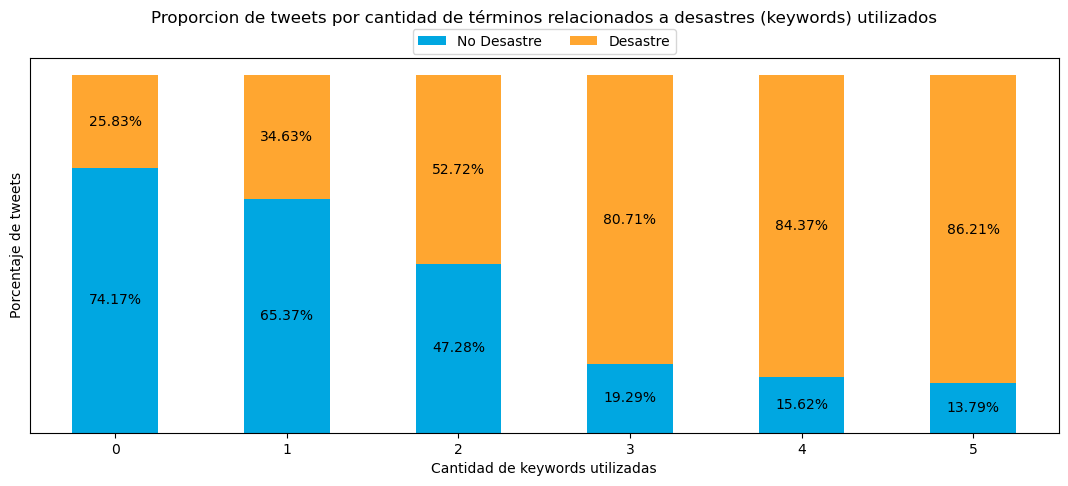

In [110]:
data = df.groupby(['disaster_terms_count','target'])["id"].nunique().unstack()
data = data[data.index <= 5]
data.columns = ['No Desastre','Desastre']
data.fillna(0, inplace=True)
fig, ax = plt.subplots(figsize=(12,6))
data.div(data.sum(axis=1), axis=0)\
    .plot(kind='bar', stacked=True, figsize=(12,6), color=CUSTOM_PALLETE, ax=ax)

for c in ax.containers:
    labels = [str(round(v.get_height()*100, 2)) + "%" if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c,
                 label_type='center',
                 labels = labels,
                 size = 10)
    
plt.title('Proporcion de tweets por cantidad de términos relacionados a desastres (keywords) utilizados', pad=25)
plt.tight_layout(pad=5)
plt.legend(ncols=2, loc='upper center', bbox_to_anchor=(0.5, 1.095))
plt.xlabel('Cantidad de keywords utilizadas')
plt.ylabel('Porcentaje de tweets')
plt.yticks(ticks=[])
plt.xticks(rotation=0)
plt.show()

### 5. Distribución de sentimiento del tweet por target

Para esta visualización utilizo la librería de código abierto `vaderSentiment`, la cual proporciona una herramienta de análisis de sentimientos en textos, especializada en redes sociales.

In [111]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def vader_scores(text):
    if not isinstance(text, str) or text.strip() == "":
        return {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}
    return analyzer.polarity_scores(text)

scores = [vader_scores(t) for t in df['text'].astype(str).tolist()]
scores_df = pd.DataFrame(scores)

df = pd.concat([df.reset_index(drop=True), scores_df.reset_index(drop=True)], axis=1)

A continuación podemos visualizar las distribuciones de las puntuaciones que proporciona `vaderSentiment`, según target.

Los primeros tres gráficos muestran los puntajes particulares (valores entre 0 y 1) para sentimiento negativo, neutro y positivo. El último gráfico muestra un puntaje "compuesto" que va desde -1 hasta 1, donde -1 representaría sentimiento completamente negativo, 0 sentimiento completamente neutro y 1 sentimiento completamente positivo.

Podemos ver distribuciones que aunque tienen diferencias son bastante similares. Para ambos targets la mayoría de tweets tienen puntajes que indican sentimientos neutros. \
En el gráfico de puntaje compuesto se observa que los tweets sobre Desastres tienen una distribución más centrada en los sentimientos negativos, lo cual puede resultar para la distinción entre las clases para los modelos de machine learning.

Se puede considerar que estas 4 columnas contienen información bastante redundante. \
Para los modelos finales resultó mejor utilizar solo la columna de puntaje compuesto. Mi hipótesis es que esto es así porque resume muy bien las otras tres columnas.

C:\Users\Patricio\AppData\Local\Temp\ipykernel_8112\3128206617.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].map(lambda x: "No Desastre" if x == 0 else "Desastre")


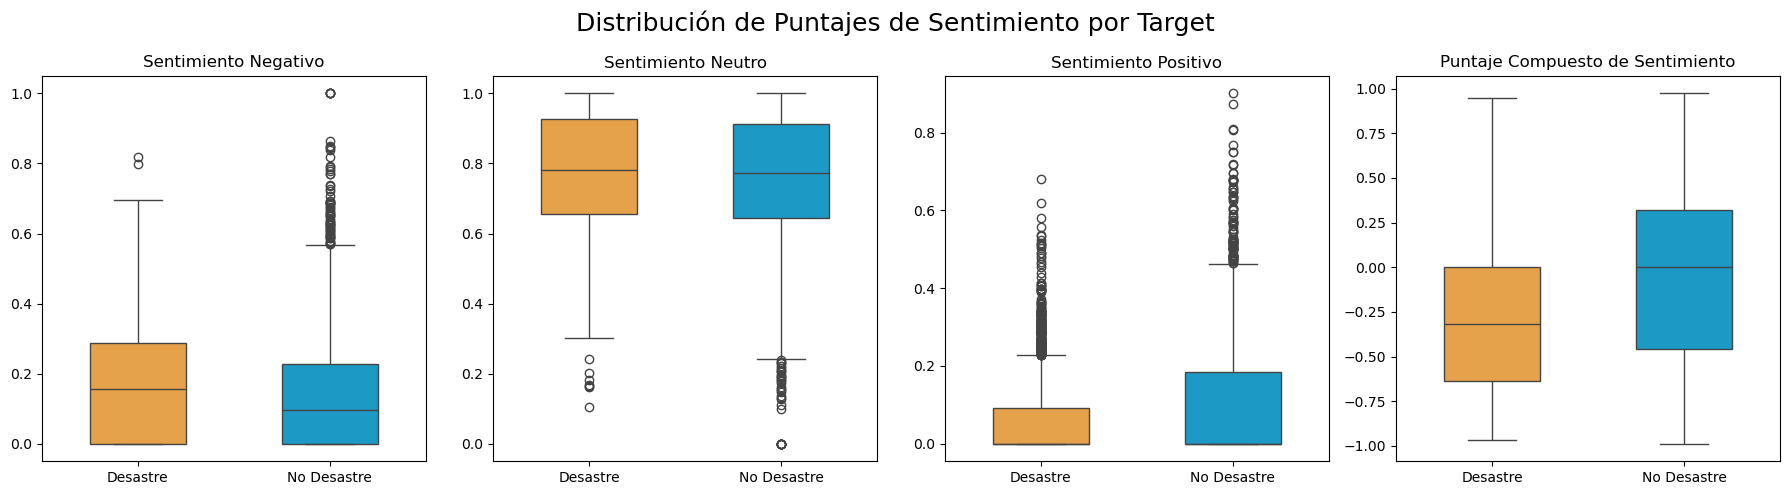

In [112]:
data=df[['target','neg','neu','pos','compound']]
data['target'] = data['target'].map(lambda x: "No Desastre" if x == 0 else "Desastre")

cols = ['neg', 'neu', 'pos', 'compound']
colnames = {
    'neg': 'Negativo',
    'neu': 'Neutro',
    'pos': 'Positivo',
    'compound': 'Compuesto'
}

fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=(18, 5))

for i, col in enumerate(cols):
    sns.boxplot(data=data, x='target', y=col, ax=axes[i], palette=CUSTOM_PALLETE[::-1], width=0.5)
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    if col != 'compound':
        axes[i].set_title(f"Sentimiento {colnames[col]}")
    else:
        axes[i].set_title("Puntaje Compuesto de Sentimiento")
fig.suptitle("Distribución de Puntajes de Sentimiento por Target", fontsize=18)

plt.tight_layout()
plt.show()

### 6. Nubes de palabras para cada target

En esta última sección se realizan visualizaciones cualitativas, donde se intentó ilustrar la incidencia de las palabras utilizadas para distinguir las clases de los tweets.

Primero se muestran dos nubes de palabras, donde el tamaño de la palabra es proporcional a la cantidad de veces que aparece entre todos los tweets de esa clase. Antes de calcular las nubes de palabras utilizo la librería `nltk` para remover las stopwords de la columna de texto formateado.

Analizando las dos nubes de palabras se pueden identificar varias palabras en común que aparecen bastante en ambas clases, por ejemplo 'amp' o 'new'. \
También pueden identificarse algunas palabras generales como 'one' o 'day' que aparecen con tamaños considerablemente diferentes en ambas nubes. \
Por último también es importante destacar que hay muchas palabras que aparecen con gran tamaño en una clase y con uno muy pequeño o directamente sin aparecer en la otra clase. Por ejemplo en la nube de Desastres se puede encontrar con tamaño considerable las palabras 'fire' 'death' 'flood' y 'hiroshima', sin embargo estas aparecen bastante pequeñas o no aparecen en la nube de No Desastres.

Los patrones recién descritos son muy simples pero nos permiten ver diferencias entre ambas clases. \
Estos patrones y muchos más (igual y más complejos) pueden ser aprendidos de manera automática por los modelos entrenados en este trabajo práctico. Es por esto que es importante encontrar una manera inteligente de representar el contenido del texto.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Patricio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


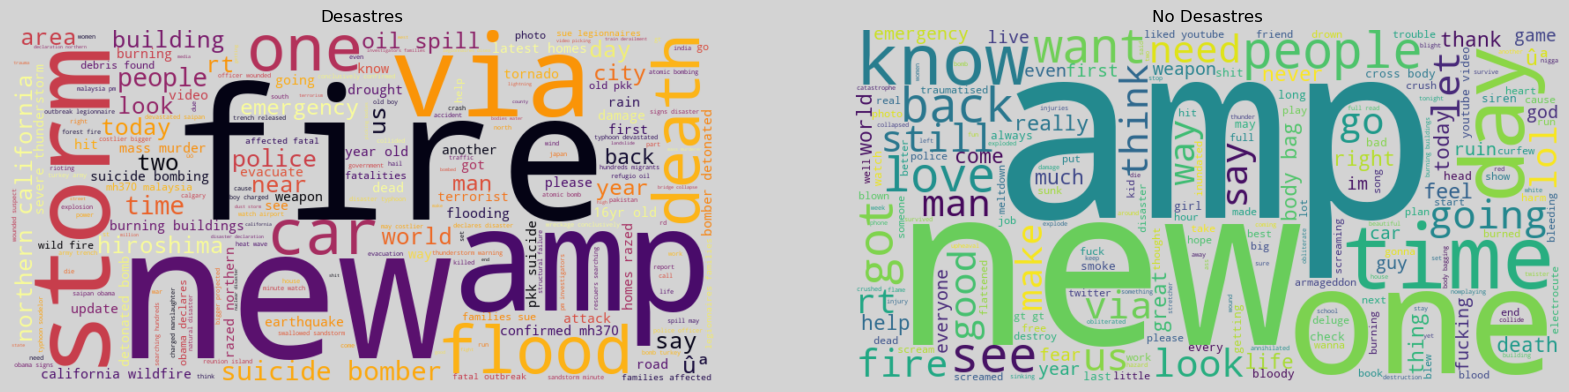

In [113]:


def generate_word_cloud(colormap, words):
    return WordCloud(
        width=800, height=400, background_color='lightgray', random_state=SEED,
        min_word_length=2, colormap=colormap,
    ).generate(words)

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
df['text_clean_nostop'] = df['text_clean'].apply(
    lambda s: ' '.join([word for word in s.split() if word not in stop_words])
)

disaster_words = ' '.join(df[df['target']==1]['text_clean_nostop'].tolist())
not_disaster_words = ' '.join(df[df['target']==0]['text_clean_nostop'].tolist())
disaster_wc = generate_word_cloud("inferno", disaster_words)
not_disaster_wc = generate_word_cloud("viridis", not_disaster_words)
fig, axes = plt.subplots(1,2, figsize=(20,8))
axes[0].imshow(disaster_wc, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Desastres')
axes[1].imshow(not_disaster_wc, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('No Desastres')
fig.patch.set_facecolor('lightgray')
plt.show()


#### Análisis de palabras importantes usando TF-IDF + RandomForest
Para hacer otro pequeño análisis de la importancia de la columna text, se me ocurrió entrenar un RandomForestClassifier utilizando únicamente esa feature. La idea es hacer un análisis rápido, por lo que no incluí búsqueda de hiperparámetros ni un procesamiento muy complejo \
Vectorizando los textos utilizando simplemente TF-IDF se obtuvo un puntaje F1 considerable, ~0.7. Con un procesamiento muy sencillo del texto, el modelo es capaz de encontrar patrones que permiten diferenciar relativamente bien las clases.

Luego, se muestra un gráfico de la importancia que el modelo le dió a cada palabra. Podemos notar importancias bastante diferentes, las palabras más importantes son 'killed' e 'hiroshima'. También es interesante notar que no todas las palabras de mayor importancia son necesariamente relacionadas a desastres (e.g. 'california' y 'like').

En la parte 4 se incuyen gráficos visualizando los tweets como vectores (reduciendo sus dimensiones), donde se pueden identificar agrupamientos que se corresponden a si los tweets son desastres o no.

F1 (validación): 0.7006802721088435


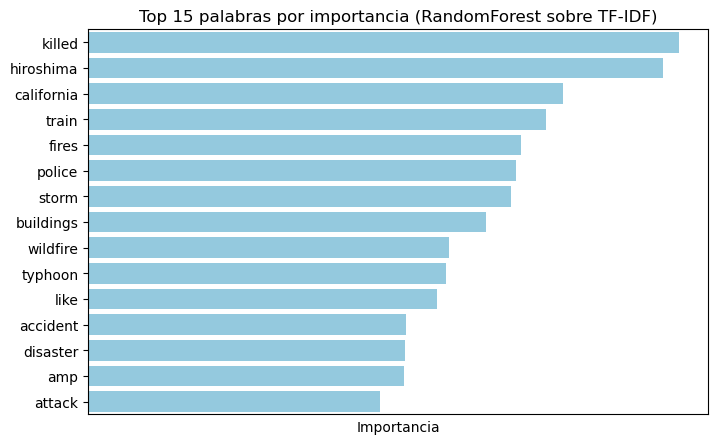

In [114]:
y = df['target'].values
X_train, X_val, y_train, y_val = train_test_split(df['text_clean'], y, test_size=0.20, random_state=SEED)
vectorizer = TfidfVectorizer(max_features=400, stop_words='english')
vectorizer.fit(X_train)
X_tfidf = vectorizer.transform(X_train)

rf = RandomForestClassifier(n_estimators=20, random_state=SEED, n_jobs=-1)
rf.fit(X_tfidf, y_train)
val_tfidf = vectorizer.transform(X_val)
y_pred = rf.predict(val_tfidf)
print('F1 (validación):', f1_score(y_val, y_pred))

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:15]
feat_names = np.array(vectorizer.get_feature_names_out())
top_words = feat_names[indices]
top_importances = importances[indices]

plt.figure(figsize=(8,5))
sns.barplot(x=top_importances, y=top_words, color='skyblue')
plt.title('Top 15 palabras por importancia (RandomForest sobre TF-IDF)')
plt.xlabel('Importancia')
plt.xticks(ticks=[])
plt.show()
